<a href="https://colab.research.google.com/github/RifatMuhtasim/Deep_Learning/blob/main/Learn/47.Using_Bert_Classify_Email_Spam_Or_Not_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow-text==2.11.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Spam'] = df['Category'].apply(lambda x: 1 if x == "spam" else 0)
df.drop(["Category"], axis="columns", inplace=True)
df.sample(5)

,Message,Spam
3567,Its ok..come to my home it vl nice to meet and...,0
4769,I'm not sure if its still available though,0
3752,"Haha... Sounds crazy, dunno can tahan anot...",0
280,All done? All handed in? Celebrations in full ...,0
3673,"came to look at the flat, seems ok, in his 50s...",0


# Under Sampling

In [5]:
spam_df = df[df['Spam'] == 1]
ham_df = df[df['Spam'] == 0]

print("Spam Email:", spam_df.shape[0])
print("Ham Email:", ham_df.shape[0])

Spam Email: 747
Ham Email: 4825


In [10]:
ds = pd.concat([spam_df, ham_df.sample(len(spam_df))], axis="rows")
ds['Spam'].value_counts()

1    747
0    747
Name: Spam, dtype: int64

In [11]:
# Train Test Split
X = ds.drop("Spam", axis="columns")
y = ds['Spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=ds['Spam'])
print(X_train.shape)
print(X_test.shape)

(1195, 1)
(299, 1)


In [12]:
y_test.value_counts()

1    150
0    149
Name: Spam, dtype: int64

# Oversampling - Not Used

In [13]:
# Create a Train df
train_df = pd.concat([X_train, y_train], axis="columns")
train_df.head()

,Message,Spam
4074,Was the actual exam harder than NBME,0
346,Gudnite....tc...practice going on,0
2263,It should take about &lt;#&gt; min,0
4079,Gam gone after outstanding innings.,0
595,I met you as a stranger and choose you as my f...,0


In [14]:
train_df['Spam'].value_counts()

0    598
1    597
Name: Spam, dtype: int64

In [15]:
spam_dfx = train_df[train_df['Spam'] == 1]
ham_dfx = train_df[train_df['Spam'] == 0]

print("Spam Email:", spam_dfx.shape[0])
print("Ham Email:", ham_dfx.shape[0])

Spam Email: 597
Ham Email: 598


## Oversampling Method

In [16]:
spam_df_balanced = pd.concat([spam_dfx] * 7, ignore_index=True)
spam_df_balanced.shape

(4179, 2)

In [17]:
dataset = pd.concat([ham_dfx, spam_df_balanced.sample(len(ham_dfx))], axis="rows")
dataset['Spam'].value_counts()

0    598
1    598
Name: Spam, dtype: int64

# Using Bert Method <a id="bert"></a>

In [ ]:
#!pip install tensorflow-hub

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [20]:
def Get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [21]:
Get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132727 , -0.88845724, ..., -0.7474888 ,
        -0.7531474 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.9444667 , ..., -0.858475  ,
        -0.7174534 ,  0.88082963]], dtype=float32)>

In [22]:
e = Get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "elon musk",
    "bill gates",
    "rifat muhtasim"
]
)

e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.1421937 ,  0.49604657, ...,  0.4216535 ,
        -0.53221387,  0.8031217 ],
       [-0.86023223, -0.21242924,  0.49156895, ...,  0.39798045,
        -0.60506284,  0.8447166 ],
       [-0.7128861 , -0.15463921,  0.38401648, ...,  0.3527873 ,
        -0.5099134 ,  0.734741  ],
       [-0.75041336, -0.26812622, -0.2668967 , ...,  0.02839388,
        -0.5938097 ,  0.7974987 ],
       [-0.7854443 , -0.2994975 ,  0.41027164, ...,  0.522253  ,
        -0.49573603,  0.81507564],
       [-0.76957434, -0.34763014, -0.01197438, ...,  0.11163151,
        -0.5598752 ,  0.7229477 ]], dtype=float32)>

In [23]:
# Show the similarity result between "Bill Gates" and "Rifat Muhtasim"
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[4]], [e[5]])

array([[0.9640354]], dtype=float32)

# Model Building with Functional

In [24]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
nnl = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
nnl = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(nnl)

# Final model
model = tf.keras.Model(inputs=[text_input], outputs=[nnl])
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [25]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(optimizer="adam", loss="binary_crossentropy", metrics= METRICS)

In [27]:
model.fit(X_train, y_train, epochs=4)

Epoch 1/4
38/38 [==============================] - 347s 9s/step - loss: 0.4559 - accuracy: 0.8544 - precision: 0.8484 - recall: 0.8626
Epoch 2/4
38/38 [==============================] - 344s 9s/step - loss: 0.3941 - accuracy: 0.8937 - precision: 0.8827 - recall: 0.9079
Epoch 3/4
38/38 [==============================] - 345s 9s/step - loss: 0.3646 - accuracy: 0.8937 - precision: 0.8917 - recall: 0.8961
Epoch 4/4
38/38 [==============================] - 343s 9s/step - loss: 0.3366 - accuracy: 0.8987 - precision: 0.8927 - recall: 0.9062


In [28]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 88s 9s/step - loss: 0.3507 - accuracy: 0.8763 - precision: 0.8192 - recall: 0.9667


[0.3506541848182678,
 0.8762542009353638,
 0.8192090392112732,
 0.9666666388511658]

In [31]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

10/10 [==============================] - 91s 9s/step


array([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [32]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86       149
           1       0.82      0.97      0.89       150

    accuracy                           0.88       299
   macro avg       0.89      0.88      0.88       299
weighted avg       0.89      0.88      0.88       299



In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[117,  32],
       [  5, 145]])

Text(50.722222222222214, 0.5, 'Truth')

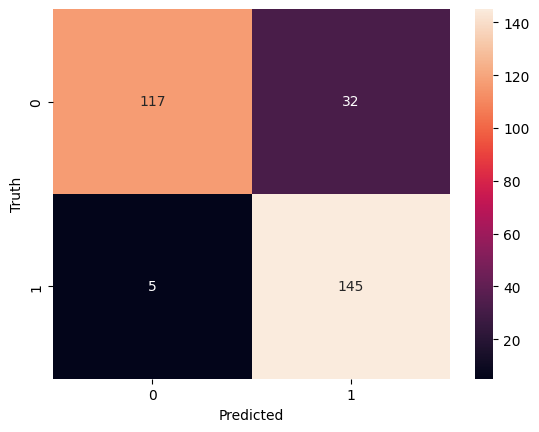

In [34]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [35]:
# Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 4s 4s/step


array([[0.7548296 ],
       [0.83104205],
       [0.81169415],
       [0.30650082],
       [0.22061212]], dtype=float32)